In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import json

In [2]:
import os
import requests
import time

# Specify the base URL of the repository
base_url = "https://huggingface.co/datasets/taesiri/AdvisingNetworksReviewDataExtension/raw/main/"

# Create a directory to store the downloaded files
os.makedirs("data", exist_ok=True)

# Send a GET request to the Hugging Face API to retrieve the list of files
api_url = "https://huggingface.co/api/datasets/taesiri/AdvisingNetworksReviewDataExtension/tree/main/data"
response = requests.get(api_url)

# Check the response status code
if response.status_code != 200:
    print(f"Error: {response.status_code} - {response.text}")
    exit(1)

# Extract the file names from the response JSON
file_names = [file["path"] for file in response.json()]

# Filter out non-JSON files
file_names = [file for file in file_names if file.endswith(".json")]

print("JSON files found:")
print(file_names)

# Download each file
for file_name in file_names:
    file_url = base_url + file_name
    file_path = os.path.join("data", os.path.basename(file_name))
    print(file_url)
    response = requests.get(file_url)

    # Check the response status code
    if response.status_code != 200:
        print(f"Error downloading {file_name}: {response.status_code} - {response.text}")
        continue

    # Save the file to the "data" directory
    with open(file_path, "wb") as file:
        file.write(response.content)

    # Add a delay to avoid rate limiting
    time.sleep(0.5)

print("All JSON files downloaded successfully.")

JSON files found:
['data/results_Akash-hkw907y5.json', 'data/results_Akash-mnh1z9pd.json', 'data/results_Akash-ppyqflna.json', 'data/results_Akash-pvnohk74.json', 'data/results_Ali-cv82rtjx.json', 'data/results_Ali-da95utwx.json', 'data/results_Ali-eox7lf8k.json', 'data/results_BXT-dczeixkh.json', 'data/results_BXT-xq1jcgnf.json', 'data/results_BXT-z2cje9z3.json', 'data/results_HaThu-1msul0lp.json', 'data/results_HaThu-gx2a557u.json', 'data/results_Hoang-lyo11e94.json', 'data/results_Hoang-weklype6.json', 'data/results_Long-edfuo4qv.json', 'data/results_Long-f5wbz5t6.json', 'data/results_Oanh-eic39nx2.json', 'data/results_Oanh-oulmw4yj.json', 'data/results_Peijie-4nez2yxb.json', 'data/results_Peijie-jl37vgrk.json', 'data/results_giang-internal-testing-mgfmqstq.json', 'data/results_giang-may-9-internal-testing-i3p2ycap.json', 'data/results_username-7qb3hafg.json', 'data/results_username-mgfmqstq.json', 'data/results_username-qvi46mph.json']
https://huggingface.co/datasets/taesiri/Advisi

  type_of_NN  ai_correctness       mean        std
0      top-1           False  33.011473  25.450257
1      top-1            True  90.524381   8.737080
2       PCNN           False  50.518051  18.922446
3       PCNN            True  84.229307   8.822403


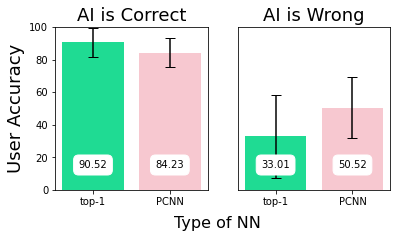

In [3]:
def calculate_the_results():
    all_jsons_path = glob('data/*.json')
    all_jsons = [json.load(open(path)) for path in all_jsons_path]

    # Initialize a DataFrame to store the results
    df = pd.DataFrame()

    for js in all_jsons:
        # read one key and determine the type of NN
        type_of_NNs = js['history'][0]['type']
        username = js['user_id']  # assuming the username is stored in the 'user_id' key
        for history in js['history']:
            was_ai_correct = history["Accept/Reject"]
#             is_user_correct = history['is_user_correct']
            is_user_correct = 1 if history['is_user_correct'] else 0  # Convert boolean to integer
            
            # Append the results to the DataFrame
            new_row = pd.DataFrame({
                'type_of_NN': [type_of_NNs], 
                'username': [username],
                'ai_correctness': [was_ai_correct], 
                'is_user_correct': [is_user_correct]
            })
            df = pd.concat([df, new_row], ignore_index=True)
    
    # in type_of_NN rename topK and topk to topQ
    df['type_of_NN'] = df['type_of_NN'].replace({'topK': 'topQ', 'topk': 'topQ'})

    # Group by 'type_of_NN', 'username' and 'ai_correctness' and calculate the mean of 'is_user_correct'
    df = df.groupby(['type_of_NN', 'username', 'ai_correctness']).mean().reset_index()

    # Calculate mean and std of user's accuracy for each group
    user_accuracy = df.groupby(['type_of_NN', 'ai_correctness'])['is_user_correct'].agg(['mean', 'std']).reset_index()
    
    return df, user_accuracy

# # Calculate the results
df, user_accuracy = calculate_the_results()


df['is_user_correct'] = df['is_user_correct'] * 100
user_accuracy['mean'] = user_accuracy['mean'] * 100
user_accuracy['std'] = user_accuracy['std'] * 100
df['type_of_NN'] = df['type_of_NN'].replace({'top1': 'top-1', 'topQ': 'PCNN'})
user_accuracy['type_of_NN'] = user_accuracy['type_of_NN'].replace({'top1': 'top-1', 'topQ': 'PCNN'})

print(user_accuracy)

fig, axs = plt.subplots(ncols=2, figsize=(6, 3))

# Define a custom palette
custom_palette = {'top-1': 'mediumspringgreen', 'PCNN': 'pink'}

# Plot the bars using seaborn with the custom palette
bar1 = sns.barplot(x='type_of_NN', y='mean', data=user_accuracy[user_accuracy['ai_correctness'] == True], 
                   ax=axs[0], palette=custom_palette, ci=None)  # Use the custom palette here

bar2 = sns.barplot(x='type_of_NN', y='mean', data=user_accuracy[user_accuracy['ai_correctness'] == False], 
                   ax=axs[1], palette=custom_palette, ci=None)  # Use the custom palette here


axs[0].errorbar(x=bar1.get_xticks(), y=user_accuracy[user_accuracy['ai_correctness'] == True]['mean'].values, 
                yerr=user_accuracy[user_accuracy['ai_correctness'] == True]['std'].values, 
                fmt='none', capsize=5, color='black')

axs[1].errorbar(x=bar2.get_xticks(), y=user_accuracy[user_accuracy['ai_correctness'] == False]['mean'].values, 
                yerr=user_accuracy[user_accuracy['ai_correctness'] == False]['std'].values, 
                fmt='none', capsize=5, color='black')

axs[0].set_title('AI Correct')
axs[0].set_ylim([0, 100])

# Add text inside the bars
for p in bar1.patches:
    bar1.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., 0), 
                   ha = 'center', va = 'bottom', 
                   xytext = (0, 20), 
                   textcoords = 'offset points',
                   color='black',
                   bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'),
                   zorder=2)

axs[1].set_title('AI Wrong')
axs[1].set_ylim([0, 100])

# Add text inside the bars
for p in bar2.patches:
    bar2.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., 0), 
                   ha = 'center', va = 'bottom', 
                   xytext = (0, 20), 
                   textcoords = 'offset points',
                   color='black',
                   bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'),
                   zorder=2)

# Remove individual x-axis labels
axs[0].set_xlabel('')
axs[1].set_xlabel('')

# Set a common label for the x-axis
fig.text(0.5, -0.05, 'Type of NN', ha='center', fontsize=16)

axs[0].set_ylabel('User Accuracy', fontsize=18)
axs[1].set_ylabel('', fontsize=18)

# hide y-axis on axs[1]
axs[1].yaxis.set_visible(False)

axs[0].set_title('AI is Correct', fontsize=18)
axs[1].set_title('AI is Wrong', fontsize=18)

# save pdf
plt.savefig('human_study_acc_by_ai_correctness_compact.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# print(user_accuracy)


In [6]:
import json
import glob
import pandas as pd

def calculate_the_results():
    all_jsons_path = glob.glob('data/*.json')
    all_jsons = [json.load(open(path)) for path in all_jsons_path]

    # Initialize a DataFrame to store the results
    df = pd.DataFrame()

    for js in all_jsons:
        type_of_NNs = js['history'][0]['type']
        username = js['user_id']
        for history in js['history']:
            was_ai_correct = history["Accept/Reject"]
            is_user_correct = 1 if history['is_user_correct'] else 0
            
            new_row = pd.DataFrame({
                'type_of_NN': [type_of_NNs], 
                'username': [username],
                'ai_correctness': [was_ai_correct], 
                'is_user_correct': [is_user_correct]
            })
            df = pd.concat([df, new_row], ignore_index=True)

    # Normalize type_of_NN labels
    df['type_of_NN'] = df['type_of_NN'].replace({'topK': 'topQ', 'topk': 'topQ'})

    # Group data by 'type_of_NN', 'username', and 'ai_correctness' to sum 'is_user_correct'
    group = df.groupby(['type_of_NN', 'username', 'ai_correctness'])
    df_summary = group.agg(
        total_correct=('is_user_correct', 'sum'),
        sample_count=('is_user_correct', 'count')
    ).reset_index()

    # Calculate user-specific accuracy percentage
    df_summary['user_accuracy'] = (df_summary['total_correct'] / df_summary['sample_count']) * 100

    # Calculate mean, std, and total samples of user's accuracy for each type_of_NN and ai_correctness group
    category_accuracy = df_summary.groupby(['type_of_NN', 'ai_correctness']).agg({
        'user_accuracy': ['mean', 'std'],
        'sample_count': 'sum'
    }).reset_index()
    
    category_accuracy_for_plot = df_summary.groupby(['type_of_NN', 'ai_correctness']).agg({
        'user_accuracy': ['mean', 'std'],
    }).reset_index()

    # Flatten multi-level column names
    category_accuracy.columns = ['type_of_NN', 'ai_correctness', 'mean_accuracy', 'std_dev', 'total_samples']
    
    category_accuracy_for_plot.columns = ['type_of_NN', 'ai_correctness', 'mean', 'std']

    # Compute overall mean accuracy for each type_of_NN across all correctness states
    overall_accuracy = category_accuracy.groupby('type_of_NN').apply(
        lambda x: np.average(x['mean_accuracy'], weights=x['total_samples'])
    ).reset_index(name='overall_mean_accuracy')

    return df_summary, category_accuracy, overall_accuracy, category_accuracy_for_plot

# Execute the function and print the results
df_summary, category_accuracy, overall_accuracy, category_accuracy_for_plot = calculate_the_results()

print("Detailed Summary by User, NN Type, and AI Correctness:")
print(df_summary)
print("\nCategory-Wide Accuracy Statistics:")
print(category_accuracy)
print("\nOverall Mean Accuracy for 'top1' and 'topQ':")
print(overall_accuracy)


Detailed Summary by User, NN Type, and AI Correctness:
   type_of_NN                               username  ai_correctness  \
0        top1                         Akash-hkw907y5           False   
1        top1                         Akash-hkw907y5            True   
2        top1                         Akash-ppyqflna           False   
3        top1                         Akash-ppyqflna            True   
4        top1                           Ali-da95utwx           False   
5        top1                           Ali-da95utwx            True   
6        top1                           Ali-eox7lf8k           False   
7        top1                           Ali-eox7lf8k            True   
8        top1                           BXT-xq1jcgnf           False   
9        top1                           BXT-xq1jcgnf            True   
10       top1                           BXT-z2cje9z3           False   
11       top1                           BXT-z2cje9z3            True   
12       

In [7]:
import json
import glob
import pandas as pd
import numpy as np

def calculate_the_results():
    all_jsons_path = glob.glob('data/*.json')
    all_jsons = [json.load(open(path)) for path in all_jsons_path]

    # Initialize a DataFrame to store the results
    df = pd.DataFrame()

    for js in all_jsons:
        type_of_NNs = js['history'][0]['type']
        username = js['user_id']
        for history in js['history']:
            was_ai_correct = history["Accept/Reject"]
            is_user_correct = 1 if history['is_user_correct'] else 0
            
            new_row = pd.DataFrame({
                'type_of_NN': [type_of_NNs], 
                'username': [username],
                'ai_correctness': [was_ai_correct], 
                'is_user_correct': [is_user_correct]
            })
            df = pd.concat([df, new_row], ignore_index=True)

    # Normalize type_of_NN labels
    df['type_of_NN'] = df['type_of_NN'].replace({'topK': 'topQ', 'topk': 'topQ'})

    # Group data by 'type_of_NN', 'username', and 'ai_correctness' to sum 'is_user_correct'
    group = df.groupby(['type_of_NN', 'username', 'ai_correctness'])
    df_summary = group.agg(
        total_correct=('is_user_correct', 'sum'),
        sample_count=('is_user_correct', 'count')
    ).reset_index()

    # Calculate user-specific accuracy percentage
    df_summary['user_accuracy'] = (df_summary['total_correct'] / df_summary['sample_count']) * 100

    # Calculate mean, std, and total samples of user's accuracy for each type_of_NN and ai_correctness group
    category_accuracy = df_summary.groupby(['type_of_NN', 'ai_correctness']).agg({
        'user_accuracy': ['mean', 'std'],
        'sample_count': 'sum'
    }).reset_index()

    # Flatten multi-level column names
    category_accuracy.columns = ['type_of_NN', 'ai_correctness', 'mean_accuracy', 'std_dev', 'total_samples']
    
    # Compute overall mean accuracy and standard deviation for each type_of_NN across all correctness states
    overall_accuracy = category_accuracy.groupby('type_of_NN').apply(
        lambda x: pd.Series({
            'weighted_mean': np.average(x['mean_accuracy'], weights=x['total_samples']),
            'weighted_std': np.sqrt(np.average((x['mean_accuracy']-np.average(x['mean_accuracy'], weights=x['total_samples']))**2, weights=x['total_samples']))
        })
    ).reset_index()

    return df_summary, category_accuracy, overall_accuracy

# Execute the function and print the results
df_summary, category_accuracy, overall_accuracy = calculate_the_results()

print("Detailed Summary by User, NN Type, and AI Correctness:")
print(df_summary)
print("\nCategory-Wide Accuracy Statistics:")
print(category_accuracy)
print("\nOverall Mean and Standard Deviation for 'top1' and 'topQ':")
print(overall_accuracy)


Detailed Summary by User, NN Type, and AI Correctness:
   type_of_NN                               username  ai_correctness  \
0        top1                         Akash-hkw907y5           False   
1        top1                         Akash-hkw907y5            True   
2        top1                         Akash-ppyqflna           False   
3        top1                         Akash-ppyqflna            True   
4        top1                           Ali-da95utwx           False   
5        top1                           Ali-da95utwx            True   
6        top1                           Ali-eox7lf8k           False   
7        top1                           Ali-eox7lf8k            True   
8        top1                           BXT-xq1jcgnf           False   
9        top1                           BXT-xq1jcgnf            True   
10       top1                           BXT-z2cje9z3           False   
11       top1                           BXT-z2cje9z3            True   
12       

In [9]:
import json
import glob
import pandas as pd
import numpy as np

def calculate_the_results():
    all_jsons_path = glob.glob('data/*.json')
    all_jsons = [json.load(open(path)) for path in all_jsons_path]

    # Initialize a DataFrame to store the results
    df = pd.DataFrame()

    for js in all_jsons:
        type_of_NNs = js['history'][0]['type']
        username = js['user_id']
        for history in js['history']:
            was_ai_correct = history["Accept/Reject"]
            is_user_correct = 1 if history['is_user_correct'] else 0
            
            new_row = pd.DataFrame({
                'type_of_NN': [type_of_NNs], 
                'username': [username],
                'ai_correctness': [was_ai_correct], 
                'is_user_correct': [is_user_correct]
            })
            df = pd.concat([df, new_row], ignore_index=True)

    # Normalize type_of_NN labels
    df['type_of_NN'] = df['type_of_NN'].replace({'topK': 'topQ', 'topk': 'topQ'})

    # Group data by 'type_of_NN', 'username', and 'ai_correctness' to sum 'is_user_correct'
    group = df.groupby(['type_of_NN', 'username', 'ai_correctness'])
    df_summary = group.agg(
        total_correct=('is_user_correct', 'sum'),
        sample_count=('is_user_correct', 'count')
    ).reset_index()

    # Calculate user-specific accuracy percentage
    df_summary['user_accuracy'] = (df_summary['total_correct'] / df_summary['sample_count']) * 100

    # Calculate mean, std, and total samples of user's accuracy for each type_of_NN and ai_correctness group
    category_accuracy = df_summary.groupby(['type_of_NN', 'ai_correctness']).agg({
        'user_accuracy': ['mean', 'std'],
        'sample_count': 'sum'
    }).reset_index()

    # Flatten multi-level column names
    category_accuracy.columns = ['type_of_NN', 'ai_correctness', 'mean_accuracy', 'std_dev', 'total_samples']
    
    # Compute overall mean accuracy and standard deviation for each type_of_NN across all correctness states
    overall_accuracy = category_accuracy.groupby('type_of_NN').apply(
        lambda x: pd.Series({
            'weighted_mean': np.average(x['mean_accuracy'], weights=x['total_samples']),
            'weighted_std': np.sqrt(np.average((x['mean_accuracy']-np.average(x['mean_accuracy'], weights=x['total_samples']))**2, weights=x['total_samples']))
        })
    ).reset_index()

    return df_summary, category_accuracy, overall_accuracy

# Execute the function and print the results
df_summary, category_accuracy, overall_accuracy = calculate_the_results()

print("Detailed Summary by User, NN Type, and AI Correctness:")
print(df_summary)
print("\nCategory-Wide Accuracy Statistics:")
print(category_accuracy)
print("\nOverall Mean and Standard Deviation for 'top1' and 'topQ':")
print(overall_accuracy)


Detailed Summary by User, NN Type, and AI Correctness:
   type_of_NN                               username  ai_correctness  \
0        top1                         Akash-hkw907y5           False   
1        top1                         Akash-hkw907y5            True   
2        top1                         Akash-ppyqflna           False   
3        top1                         Akash-ppyqflna            True   
4        top1                           Ali-da95utwx           False   
5        top1                           Ali-da95utwx            True   
6        top1                           Ali-eox7lf8k           False   
7        top1                           Ali-eox7lf8k            True   
8        top1                           BXT-xq1jcgnf           False   
9        top1                           BXT-xq1jcgnf            True   
10       top1                           BXT-z2cje9z3           False   
11       top1                           BXT-z2cje9z3            True   
12       

In [11]:
import json
import glob
import pandas as pd
import numpy as np

def calculate_the_results():
    all_jsons_path = glob.glob('data/*.json')
    all_jsons = [json.load(open(path)) for path in all_jsons_path]

    df = pd.DataFrame()
    for js in all_jsons:
        type_of_NNs = js['history'][0]['type']
        username = js['user_id']
        for history in js['history']:
            was_ai_correct = history["Accept/Reject"]
            is_user_correct = 1 if history['is_user_correct'] else 0
            
            new_row = pd.DataFrame({
                'type_of_NN': [type_of_NNs], 
                'username': [username],
                'ai_correctness': [was_ai_correct], 
                'is_user_correct': [is_user_correct]
            })
            df = pd.concat([df, new_row], ignore_index=True)

    df['type_of_NN'] = df['type_of_NN'].replace({'topK': 'topQ', 'topk': 'topQ'})

    group = df.groupby(['type_of_NN', 'username', 'ai_correctness'])
    df_summary = group.agg(
        total_correct=('is_user_correct', 'sum'),
        sample_count=('is_user_correct', 'count')
    ).reset_index()
    df_summary['user_accuracy'] = (df_summary['total_correct'] / df_summary['sample_count']) * 100

    category_accuracy = df_summary.groupby(['type_of_NN', 'ai_correctness']).agg({
        'user_accuracy': ['mean', 'std'],
        'sample_count': 'sum'
    }).reset_index()
    category_accuracy.columns = ['type_of_NN', 'ai_correctness', 'mean_accuracy', 'std_dev', 'total_samples']

    overall_accuracy = category_accuracy.groupby('type_of_NN').apply(
        lambda x: pd.Series({
            'weighted_mean': np.average(x['mean_accuracy'], weights=x['total_samples']),
            'weighted_std': np.sqrt(np.average((x['mean_accuracy'] - x['mean_accuracy'].mean())**2, weights=x['total_samples']))
        })
    ).reset_index()

    return df_summary, category_accuracy, overall_accuracy

# Execute the function and print the results
df_summary, category_accuracy, overall_accuracy = calculate_the_results()

print("Detailed Summary by User, NN Type, and AI Correctness:")
print(df_summary)
print("\nCategory-Wide Accuracy Statistics:")
print(category_accuracy)
print("\nOverall Mean and Standard Deviation for 'top1' and 'topQ':")
print(overall_accuracy)


Detailed Summary by User, NN Type, and AI Correctness:
   type_of_NN                               username  ai_correctness  \
0        top1                         Akash-hkw907y5           False   
1        top1                         Akash-hkw907y5            True   
2        top1                         Akash-ppyqflna           False   
3        top1                         Akash-ppyqflna            True   
4        top1                           Ali-da95utwx           False   
5        top1                           Ali-da95utwx            True   
6        top1                           Ali-eox7lf8k           False   
7        top1                           Ali-eox7lf8k            True   
8        top1                           BXT-xq1jcgnf           False   
9        top1                           BXT-xq1jcgnf            True   
10       top1                           BXT-z2cje9z3           False   
11       top1                           BXT-z2cje9z3            True   
12       

In [13]:
import json
import glob
import pandas as pd
import numpy as np

def calculate_the_results():
    all_jsons_path = glob.glob('data/*.json')
    all_jsons = [json.load(open(path)) for path in all_jsons_path]

    df = pd.DataFrame()
    for js in all_jsons:
        type_of_NNs = js['history'][0]['type']
        username = js['user_id']
        for history in js['history']:
            was_ai_correct = history["Accept/Reject"]
            is_user_correct = 1 if history['is_user_correct'] else 0
            
            new_row = pd.DataFrame({
                'type_of_NN': [type_of_NNs], 
                'username': [username],
                'ai_correctness': [was_ai_correct], 
                'is_user_correct': [is_user_correct]
            })
            df = pd.concat([df, new_row], ignore_index=True)

    df['type_of_NN'] = df['type_of_NN'].replace({'topK': 'topQ', 'topk': 'topQ'})

    group = df.groupby(['type_of_NN', 'username', 'ai_correctness'])
    df_summary = group.agg(
        total_correct=('is_user_correct', 'sum'),
        sample_count=('is_user_correct', 'count')
    ).reset_index()
    df_summary['user_accuracy'] = (df_summary['total_correct'] / df_summary['sample_count']) * 100

    category_accuracy = df_summary.groupby(['type_of_NN', 'ai_correctness']).agg({
        'user_accuracy': ['mean', 'std'],
        'sample_count': 'sum'
    }).reset_index()
    category_accuracy.columns = ['type_of_NN', 'ai_correctness', 'mean_accuracy', 'std_dev', 'total_samples']

    overall_accuracy = category_accuracy.groupby('type_of_NN').apply(
        lambda x: pd.Series({
            'weighted_mean': np.average(x['mean_accuracy'], weights=x['total_samples']),
            'weighted_std': np.sqrt(np.sum(x['total_samples'] * (x['mean_accuracy'] - np.average(x['mean_accuracy'], weights=x['total_samples']))**2) / np.sum(x['total_samples']))
        })
    ).reset_index()

    return df_summary, category_accuracy, overall_accuracy

# Execute the function and print the results
df_summary, category_accuracy, overall_accuracy = calculate_the_results()

print("Detailed Summary by User, NN Type, and AI Correctness:")
print(df_summary)
print("\nCategory-Wide Accuracy Statistics:")
print(category_accuracy)
print("\nOverall Mean and Standard Deviation for 'top1' and 'topQ':")
print(overall_accuracy)


Detailed Summary by User, NN Type, and AI Correctness:
   type_of_NN                               username  ai_correctness  \
0        top1                         Akash-hkw907y5           False   
1        top1                         Akash-hkw907y5            True   
2        top1                         Akash-ppyqflna           False   
3        top1                         Akash-ppyqflna            True   
4        top1                           Ali-da95utwx           False   
5        top1                           Ali-da95utwx            True   
6        top1                           Ali-eox7lf8k           False   
7        top1                           Ali-eox7lf8k            True   
8        top1                           BXT-xq1jcgnf           False   
9        top1                           BXT-xq1jcgnf            True   
10       top1                           BXT-z2cje9z3           False   
11       top1                           BXT-z2cje9z3            True   
12       

In [5]:
user_accuracy_details = df.groupby(['type_of_NN', 'ai_correctness'])['is_user_correct'].agg(['mean', 'std', 'count']).reset_index()
print(user_accuracy_details)
counts = {
    'top-1_correct': int(user_accuracy_details[(user_accuracy_details['type_of_NN'] == 'top-1') & (user_accuracy_details['ai_correctness'] == True)]['count']),
    'top-1_wrong': int(user_accuracy_details[(user_accuracy_details['type_of_NN'] == 'top-1') & (user_accuracy_details['ai_correctness'] == False)]['count']),
    'PCNN_correct': int(user_accuracy_details[(user_accuracy_details['type_of_NN'] == 'PCNN') & (user_accuracy_details['ai_correctness'] == True)]['count']),
    'PCNN_wrong': int(user_accuracy_details[(user_accuracy_details['type_of_NN'] == 'PCNN') & (user_accuracy_details['ai_correctness'] == False)]['count'])
}

print(f"Number of data points for 'top-1' when AI is correct: {counts['top-1_correct']}")
print(f"Number of data points for 'top-1' when AI is wrong: {counts['top-1_wrong']}")
print(f"Number of data points for 'PCNN' when AI is correct: {counts['PCNN_correct']}")
print(f"Number of data points for 'PCNN' when AI is wrong: {counts['PCNN_wrong']}")

  type_of_NN  ai_correctness       mean        std  count
0       PCNN           False  50.518051  18.922446     12
1       PCNN            True  84.229307   8.822403     12
2      top-1           False  33.011473  25.450257     14
3      top-1            True  90.524381   8.737080     14
Number of data points for 'top-1' when AI is correct: 14
Number of data points for 'top-1' when AI is wrong: 14
Number of data points for 'PCNN' when AI is correct: 12
Number of data points for 'PCNN' when AI is wrong: 12
